In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (
    basis,
    tensor,
    sigmam,
    sigmap,
    ket2dm,
    expect,
    qeye
)

In [2]:
# --- 1. PARAMETRELER (Senin kodundaki yapıyı koruyoruz) ---
# Collision Modelde "zaman" kavramı "çarpışma sayısı"dır.
# t = n * tau (n: adım sayısı, tau: etkileşim süresi)
tau = np.pi/30           # Her bir çarpışmanın süresi (Interaction time)
N_steps = 1000       # Toplam adım sayısı (tlist yerine geçecek)
g = 1.0             # Bağlanma gücü (Coupling strength)

In [3]:
# --- 2. BAŞLANGIÇ DURUMU ---
# Senin kodundaki gibi Süperpozisyon durumu: (|0> + |1>) / sqrt(2)
psi_S = (basis(2, 0) + basis(2, 1)).unit()
rho_S = ket2dm(psi_S) # Yoğunluk matrisi

# Çevre (Ancilla) Durumu: Her zaman taze ve soğuk (|0>)
rho_E_init = ket2dm(basis(2, 0))

In [4]:
# --- 3. ETKİLEŞİM HAMILTONIAN'I ---
# Amplitude Damping (Enerji Kaybı) yaratan etkileşim:
# Sistem enerjiyi (sp) çevreye (sm) verir + tam tersi.
# H_int = g * (sigma_plus^S * sigma_minus^E + sigma_minus^S * sigma_plus^E)
sp = sigmap()
sm = sigmam()
H_int = g * (tensor(sp, sm) + tensor(sm, sp))

# Unitary Operatör (Tek bir çarpışma için zaman evrimi)
U = (-1j * H_int * tau).expm()

In [5]:
U

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[1.       +0.j         0.       +0.j         0.       +0.j
  0.       +0.j        ]
 [0.       +0.j         0.9945219+0.j         0.       -0.10452846j
  0.       +0.j        ]
 [0.       +0.j         0.       -0.10452846j 0.9945219+0.j
  0.       +0.j        ]
 [0.       +0.j         0.       +0.j         0.       +0.j
  1.       +0.j        ]]

In [6]:
# --- 4. SİMÜLASYON DÖNGÜSÜ (Collision Model) ---
# Verileri saklayacağımız listeler
populations = []  # <1|rho|1>
coherences = []   # Normalize edilmiş koherans (2 * |rho_01|)
times = []        # Zaman ekseni

rho_total = tensor(rho_S, rho_E_init)  # Başlangıçta sistem + çevre

for n in range(N_steps):
    # a. Ölçüm (Observer)
    # Popülasyon (Excited state doluluğu)
    pop = expect(rho_S, basis(2, 1))
    populations.append(pop)

    rho_total = tensor(rho_S, rho_E_init)  # Her adımda taze çevre
    
    # Koherans (Süperpozisyonun gücü)
    # Senin kodundaki sigma_x beklendik değeri yerine, doğrudan
    # yoğunluk matrisinin off-diagonal elemanına bakmak daha temizdir.
    # Normalize etmek için 2 ile çarpıyoruz (Başlangıç 1 olsun diye).
    coh = 2*rho_S[0, 1]
    coherences.append(coh)
    
    # Zamanı kaydet
    times.append(n)
    
    # b. Çarpışma (Interaction)
    # Sistem ile TAZE bir çevre kübitini yan yana getir
    

    # Birlikte evrilsinler (U * rho * U_dag)
    rho_total = U * rho_total * U.dag()
    
    # c. Çevreyi At (Trace Out)
    rho_S = rho_total.ptrace(0) # Keep system only(index 0), discard environment(index 1)


c:\Users\yaucu\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\yaucu\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


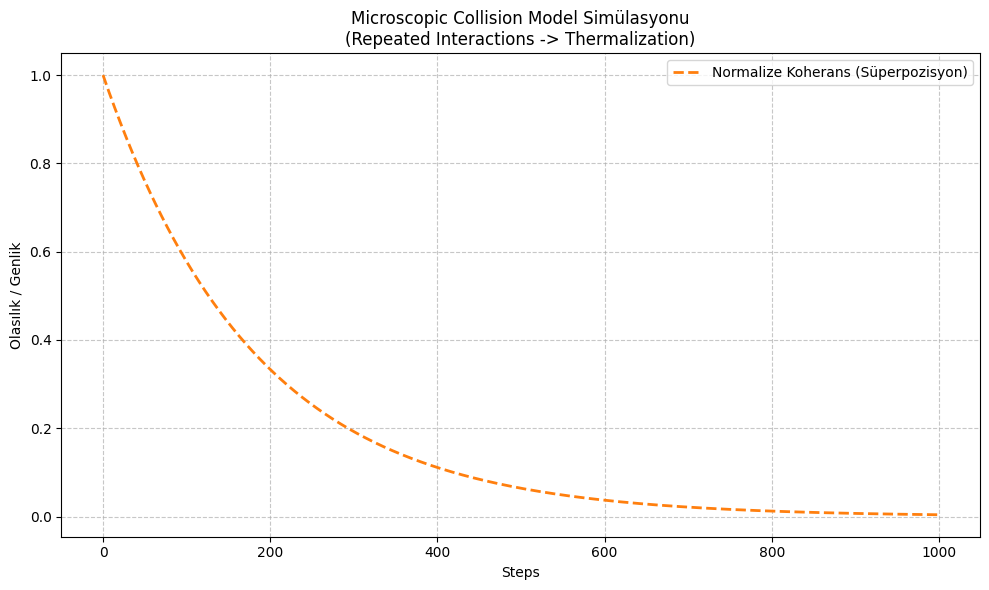

In [7]:
# --- 5. GÖRSELLEŞTİRME (Senin grafik stilinle) ---
plt.figure(figsize=(10, 6))



# Koherans Çizgisi
plt.plot(
    times,
    coherences,
    label=r'Normalize Koherans (Süperpozisyon)',
    linewidth=2,
    linestyle='--',
    color='tab:orange'
)

plt.title("Microscopic Collision Model Simülasyonu\n(Repeated Interactions -> Thermalization)")
plt.xlabel("Steps")
plt.ylabel("Olasılık / Genlik")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()







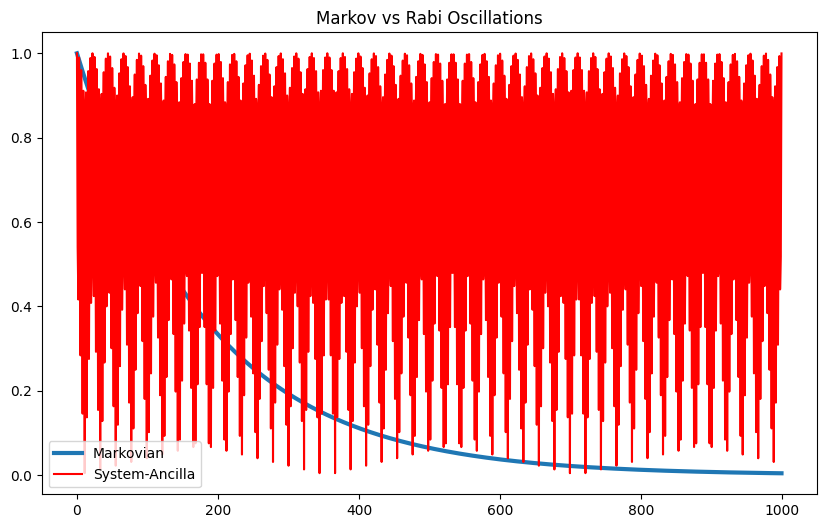

In [8]:
#### Rabi Oscillations if ancilla never outed

# Analitik Çözüm (Teorik Formül)
analytical_coherences = [1 * abs(np.cos(g * t)) for t in times] # Katsayı 1/2 olabilir veya başlangıca göre 1

plt.figure(figsize=(10, 6))
# Simülasyon (Çizgi)
plt.plot(times, coherences, label='Markovian', linewidth=3, color='tab:blue')
# Analitik (Nokta)
plt.plot(times, analytical_coherences, label='System-Ancilla', color='red', markersize=4)

plt.title("Markov vs Rabi Oscillations")
plt.legend()
plt.show()

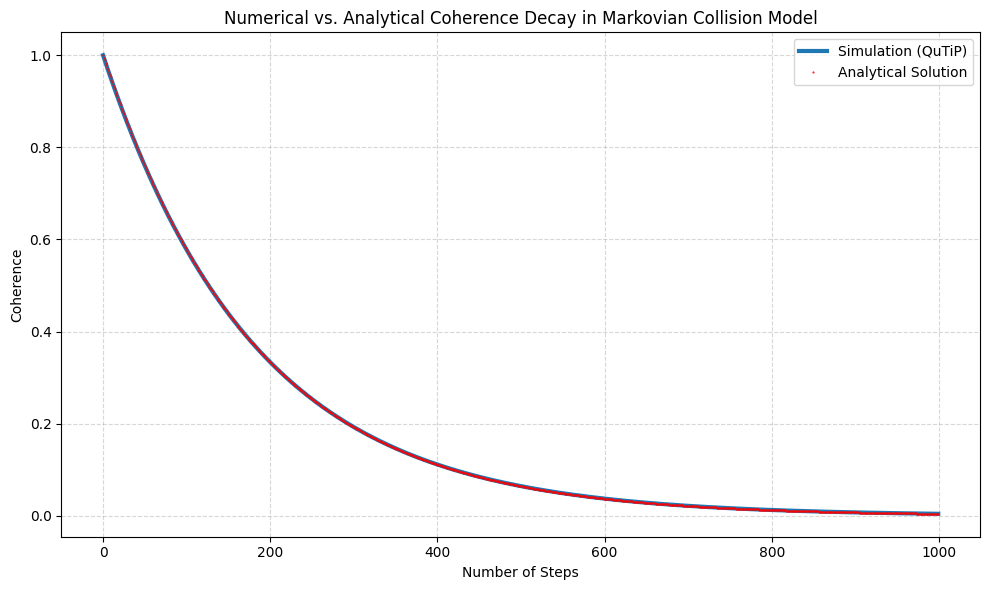

In [10]:
# --- 5. GÖRSELLEŞTİRME (DÜZELTİLMİŞ TEORİ) ---
plt.figure(figsize=(10, 6))

# Simülasyon Sonuçları (Çizgi)
plt.plot(
    times,
    coherences,
    label='Simulation (QuTiP)',
    linewidth=3,
    color='tab:blue'
)

# --- Analitik Teori (Collision Model Mantığı) ---
# Mantık: Her adımda koherans "cos(g*tau)" çarpanı kadar azalır.
# n. adımda toplam koherans: (cos(g*tau))^n olur.

decay_factor = np.cos(g * tau)  # Tek bir çarpışmadaki kayıp faktörü (0.995 gibi bir sayı)
steps = np.arange(len(times))   # Adım sayıları: 0, 1, 2, ...

# Eğer cos(g*tau) pozitifse, üssünü aldığımızda hep pozitif kalır.
# Başlangıç koheransı 1.0 kabul edildi (Normalize).
analytical_coherences = 1.0 * (decay_factor ** steps) #cos(g*tau)^n 

# Analitik Sonuçlar (Kırmızı Noktalar)
plt.plot(
    times,
    analytical_coherences,
    'o',
    label='Analytical Solution',
    color='red',
    markersize=0.5
)


plt.title("Numerical vs. Analytical Coherence Decay in Markovian Collision Model")
plt.xlabel("Number of Steps")
plt.ylabel("Coherence")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()